# Compare MB gradients 

#### plot the thickness difference for an individual glacier between OGGM linear gradient and a user defined mass balance gradient

In [4]:
##Ben Pelto June 2019

# Python imports
import os
import pandas as pd
import salem
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

font = {'family' : 'Optima',
        'weight' : 'normal',
        'size'   : 9}

plt.rc('font', **font)

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer
- 7 Castle Creek

In [5]:
num = 0 #num determines which gdir and gradient to use

#observational data points gradients
grad = [6.84, 9.8, 7.11, 9.8, 10.84, 6.01, 7.92, 7.19] # mm w.e. m-1 

fl_smooth = 1  # Gaussian smooth of the altitude along a flowline 
# sigma, in pixel coordinates (sigma=1 -> smooth around a -4:+4 window)

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48, -6.00]
products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'W.Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer', 'Castle']

WORKING_DIR = utils.get_temp_dir('test_thick' + glacier[num])
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

# dx = 100 
# cfg.PARAMS['use_rgi_area'] = False
cfg.PARAMS['border'] = 10
cfg.PARAMS['flowline_height_smooth'] = fl_smooth

cfg.PARAMS['smooth_window'] = 70.

#testing effect of larger grid cell size
# cfg.PARAMS['grid_dx_method'] = 'fixed'
# cfg.PARAMS['fixed_dx'] = dx
if glacier[num] == 'W.Washmawapta' or 'Nordic':
    cfg.PARAMS['use_intersects'] = False
    
    # Get the RGI IDs for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688',
            'RGI60-02.04264', 'RGI60-02.07780', 'RGI60-02.08783']

2019-11-18 16:32:47: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


In [6]:
rgidf = utils.get_rgi_glacier_entities([rgi_list[num]]) # Get a list of glacier outlines selected by RGI IDs
gdirs = workflow.init_glacier_regions(rgidf) # Initializes the list of Glacier Directories for this run
workflow.gis_prepro_tasks(gdirs)        # runs all flowline preprocessing tasks
workflow.climate_tasks(gdirs)           # runs all climate related tasks
workflow.inversion_tasks(gdirs)         #runs all ice thickness inversion tasks
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs[0]
tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

2019-11-18 16:32:48: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-11-18 16:32:48: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-11-18 16:32:48: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-11-18 16:32:48: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-11-18 16:32:48: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-11-18 16:32:49: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-11-18 16:32:49: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-11-18 16:32:49: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-11-18 16:32:49: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anacon

In [7]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.801 km2
  Lon, Lat: (-117.137, 49.749)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

In [8]:
# Print the standard MB gradient from OGGM default
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
# gdir = gdirs[num]

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

# grad_line = np.polyfit(mb_on_z,z,2)
from scipy import stats 
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

slope: 4.039324    intercept: -10645.995691   R-squared: 0.999420


/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Optima'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


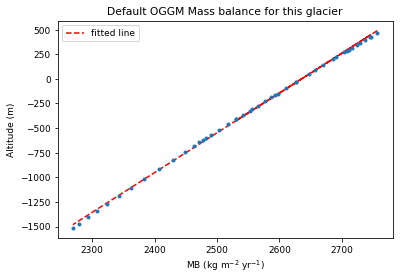

In [9]:
plt.plot(z, intercept + slope*z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

In [10]:
# See the result of the inversion
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2019-11-18 16:32:52: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


In [11]:
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

In [12]:
# ds_default.distributed_thickness.plot();
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
thickness_default.mean()

51.212509834446315

In [13]:
default_thick = thickness_default[thickness_default>0].mean()
print('default flowline thickness:', np.round(default_thick,2))

default flowline thickness: 58.33


In [14]:
# Let's apply a linear MB instead
from oggm.core.climate import apparent_mb_from_linear_mb
# gdir = gdirs[num]
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

2019-11-18 16:32:52: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers


In [15]:
# Compare what we got from this
from oggm.core.massbalance import LinearMassBalance

params = gdir.read_pickle('linear_mb_params')
print(params)

#max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'], max_mb=2000.)
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

{'ela_h': 2580.933362890791, 'grad': 6.84}


slope default: 4.039324    intercept: -10645.995691   R-squared: 0.999420
slope: 6.840000    intercept: -17653.584202   R-squared: 1.000000


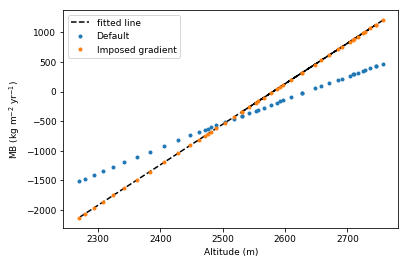

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(z, l_mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

plt.plot(z, intercept + slope*z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

In [17]:
# Now let's recompute the inversion based on this new gradient
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

2019-11-18 16:32:52: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2019-11-18 16:32:52: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-11-18 16:32:52: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2019-11-18 16:32:52: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2019-11-18 16:32:52: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers


In [18]:
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

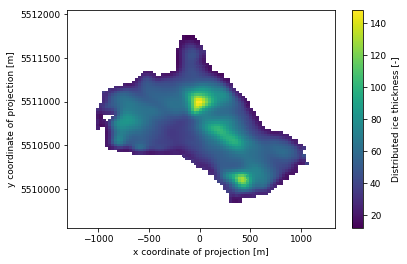

In [19]:
ds_new.distributed_thickness.plot();

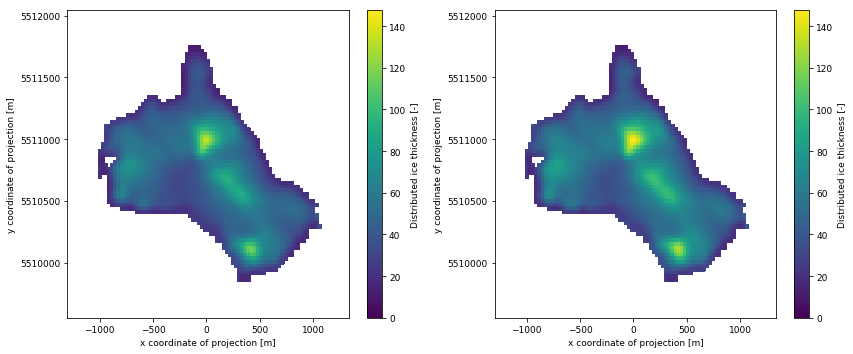

In [20]:
##side by side thickness...fine but hard to compare
vmax= ds_new.distributed_thickness.max()
vmin=0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_default.distributed_thickness.plot(ax=ax1, vmin=vmin, vmax=vmax); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2, vmin=vmin, vmax=vmax);
plt.tight_layout();

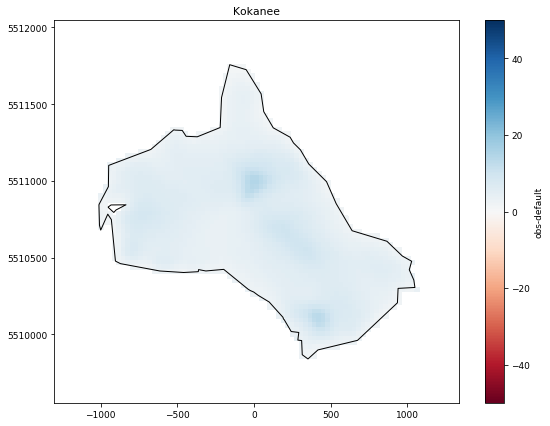

In [21]:
#plot thickness difference between the default SMB grad. inversion and in situ SMB grad. inversion
f, ax = plt.subplots(figsize=(8,6))
ds_new['obs-default'] = (ds_new.distributed_thickness - ds_default.distributed_thickness)
ds_new['obs-default'].plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

In [22]:
# "whole glacier thickness"
print(np.mean(ds_new.distributed_thickness))
print(ds_default.distributed_thickness.mean())

<xarray.DataArray 'distributed_thickness' ()>
array(52.86084, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(47.480255, dtype=float32)


In [23]:
mfl=gdir.read_pickle('model_flowlines')
thickness_MB = mfl[-1].surface_h - mfl[-1].bed_h
thickness_MB.mean()

56.96470190628683

Flowline glacier thickness:

In [24]:
MB_thick = thickness_MB[thickness_MB>0].mean()
print(np.round(MB_thick , 2))

64.88


In [25]:
diff =  MB_thick - default_thick
print(np.round(diff, 2))

6.55


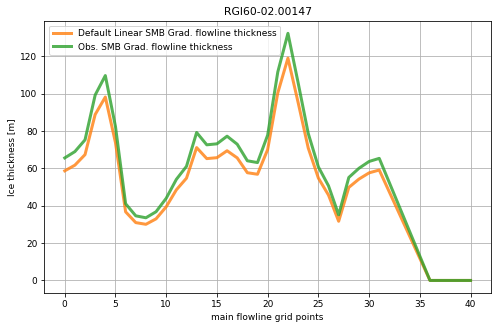

In [26]:
fig, ax = plt.subplots(figsize=[8,5])
ax.plot(thickness_default, 'C1', label='Default Linear SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_MB, 'C2', label='Obs. SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
fig.savefig(products_dir + glacier[num] +'.tiff')

In [27]:
ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
# List all variables
ds.close()

In [28]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# graphics.plot_raster(gdir, var_name='aspect', cmap='twilight', ax=ax1)
# graphics.plot_raster(gdir, var_name='oggm_mb_above_z', ax=ax2)

# Import GPR observations

In [29]:
shapefile = ['2017/Kokanee_17_final_WGS84_clip.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84_clipped.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']

##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now

df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[num])

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

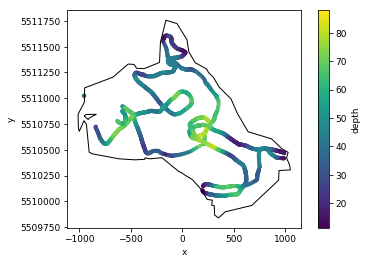

In [30]:
# Convert the longitudes and latitudes to the glacier map projection:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

#plot these data
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth',cmap='viridis', s=10, ax=ax); #cmap='Blues',
geom.plot(ax=ax, facecolor='none', edgecolor='k');

The measurement points of this dataset are very frequent and close to each other. There are plenty of them:

In [31]:
len(df)

1856

In [32]:
# Here, we will keep them all and interpolate the variables of interest at a the point's location. 
# We use xarray for this:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
#        'oggm_mb_above_z',
#        'oggm_mb_above_z_on_catch',
       ]

In [33]:
# Interpolate (bilinear)
for vn in vns:
    df[vn] = ds[vn].interp(x=('z', df.x), y=('z', df.y))

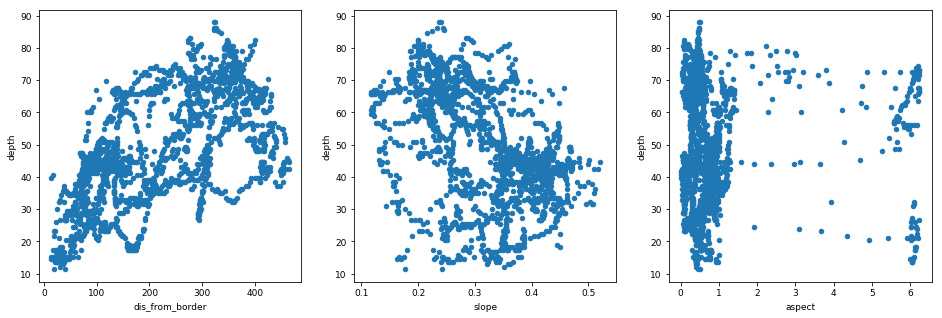

In [34]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df.plot.scatter(x='slope', y='depth', ax=ax2);
df.plot.scatter(x='aspect', y='depth', ax=ax3);

### Method 2: aggregated per grid point

There are so many points that much of the information obtained by OGGM is interpolated. A way to deal with this is to aggregate all the measurement points per grid point and average them. Let's do this: 

In [35]:
df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [36]:
# Select
for vn in vns:
    df_agg[vn] = ds[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))

In [37]:
print(len(df_agg))
points_diff = (len(df) / len(df_agg))
print('We now have',  np.round(points_diff, 1), 'times less points, but the main features of the data remain unchanged:')

390
We now have 4.8 times less points, but the main features of the data remain unchanged:


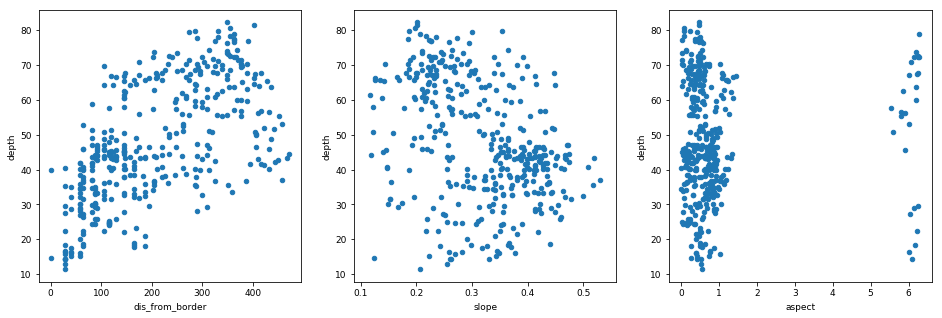

In [38]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

In [39]:
# Add the linear model data for comparison
# ds = xr.open_dataset(gdir.get_filepath('gridded_data'))
df_agg['oggm_thick'] = ds_default.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['obs_mb_grad_thick'] = ds_new.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))

In [40]:
print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('oggm_thick', np.round(np.mean(df_agg['oggm_thick']) + srtm[num],2), '+/-' , np.round(np.std(df_agg['oggm_thick'])))
print('obs_mb_grad_thick', np.round(np.mean(df_agg['obs_mb_grad_thick'])+ srtm[num],2), '+/-' , np.round(np.std(df_agg['obs_mb_grad_thick']),2))
thickness_GPR = df_agg['depth']
GPR_thick = thickness_GPR[thickness_GPR>0].mean()
print('GPR depth (m):', np.round(GPR_thick, 2), '+/-' ,  np.round(np.std(df_agg['depth']),2))

390 390
oggm_thick 54.1 +/- 19.0
obs_mb_grad_thick 60.38 +/- 20.78
GPR depth (m): 47.73 +/- 16.83


In [41]:
print('mean observed depth point:', np.round(df['depth'].mean(),2))
print('max observed depth gridded:', np.round(thickness_GPR.max(),2))
print('max observed depth point:', df['depth'].max())

mean observed depth point: 48.32
max observed depth gridded: 82.23
max observed depth point: 87.88


In [42]:
df_diff = df_agg['depth'] - (df_agg['oggm_thick']) #- 1.0)

print('mean diff:', np.mean(df_diff))
print('med. diff:', np.nanmedian(df_diff))

mean diff: -7.9283522656035395
med. diff: -6.612547302246099


In [43]:
df_diff2 = df_agg['depth'] - (df_agg['obs_mb_grad_thick']) #- 1.0)

#df_diff
print('mean diff:', np.mean(df_diff2))
print('med. diff:', np.nanmedian(df_diff2))

mean diff: -14.212086094425194
med. diff: -12.916716512044275


In [44]:
df_agg['perc_diff_GPR_obs_smb'] = (np.abs(df_agg['depth'] - df_agg['oggm_thick'])) / ((df_agg['depth'] + df_agg['oggm_thick'])/2.)
df_agg

,lon,lat,depth,i,j,topo,slope,slope_factor,aspect,dis_from_border,oggm_thick,obs_mb_grad_thick,perc_diff_GPR_obs_smb
ij,,,,,,,,,,,,,
0011_0035,-117.150259,49.751700,40.470000,11,35,2689.0,0.146998,3.159459,0.404724,29.000000,NaN,NaN,NaN
0012_0035,-117.150204,49.751700,39.790000,12,35,2687.0,0.186534,2.738707,0.880784,0.000000,25.760998,28.749426,0.428033
0015_0045,-117.148661,49.748968,31.540000,15,45,2679.0,0.152847,3.086360,0.719948,64.845970,50.766071,56.658440,0.467185
0015_0046,-117.148626,49.748860,32.230000,15,46,2684.0,0.195800,2.660190,0.659550,58.000000,46.371864,51.756397,0.359835
0016_0046,-117.148522,49.748730,30.160000,16,46,2683.0,0.149385,3.129076,0.369439,87.000000,58.648258,65.457664,0.641568
0016_0047,-117.148385,49.748518,29.236667,16,47,2687.0,0.167262,2.923894,0.417227,87.000000,54.761978,61.123631,0.607755
0016_0048,-117.148257,49.748325,30.505000,16,48,2692.0,0.173664,2.858737,0.478445,87.000000,53.075600,59.245220,0.540092
0017_0048,-117.148166,49.748172,36.365000,17,48,2690.0,0.154504,3.066453,0.153329,116.000000,60.835861,67.906639,0.503511
0017_0049,-117.148055,49.747968,40.608000,17,49,2695.0,0.146292,3.168603,0.107307,116.000000,61.757538,68.940674,0.413216


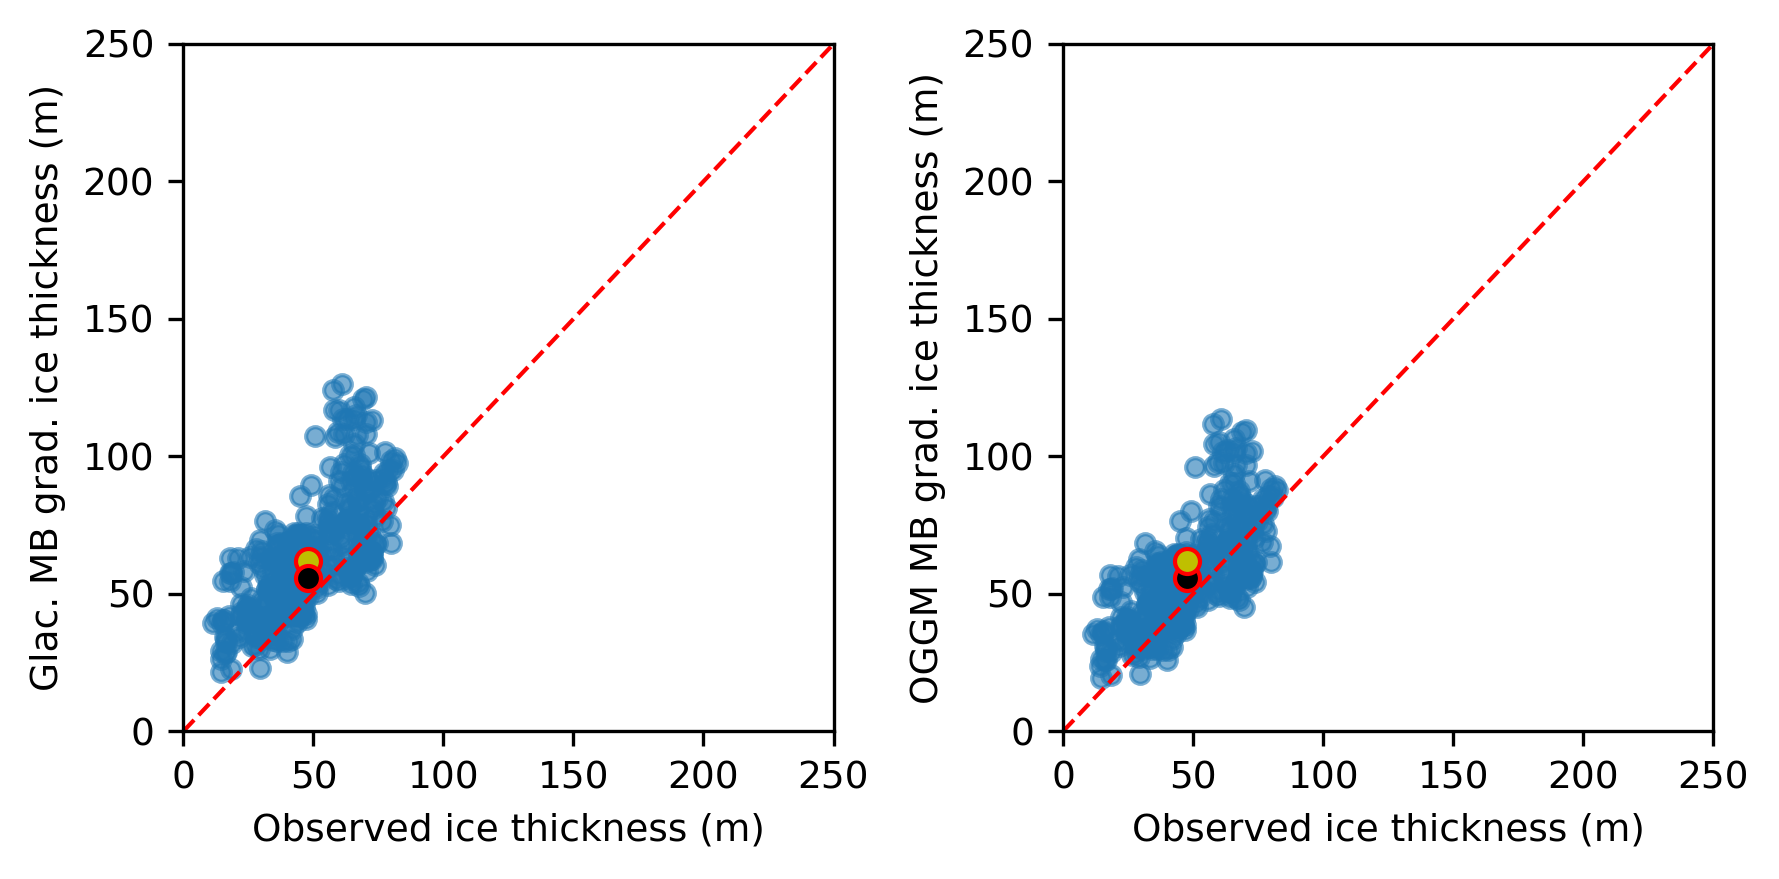

In [45]:
val = 250

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=300);

df_agg.plot.scatter(x='depth', y='obs_mb_grad_thick', ax=ax1, alpha=0.6);
ax1.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax1.set_xlabel('Observed ice thickness (m)')  #, fontsize=12)
ax1.set_ylabel('Glac. MB grad. ice thickness (m)') # , fontsize=12)
ax1.set_xlim([0, val]);
ax1.set_ylim([0, val]);

df_agg.plot.scatter(x='depth', y='oggm_thick', ax=ax2, alpha=0.6);
ax2.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax2.set_xlabel('Observed ice thickness (m)') #, fontsize=12)
ax2.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax2.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
ax2.set_xlim([0, val]);
ax2.set_ylim([0, val]);
ax2.set_ylabel('OGGM MB grad. ice thickness (m)') #, fontsize=12)

# plt.legend()
plt.tight_layout()
plt.savefig(products_dir + glacier[num] + '_MB_grads_vs_gpr_ice_thick.png')

##need to correct for SRTM height change to asess performance

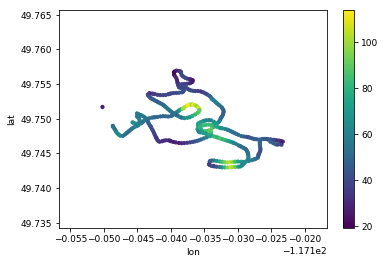

In [46]:
#plot these data
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
# diff = df_agg['oggm_thick'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['oggm_thick'], cmap='viridis', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='none', edgecolor='k');

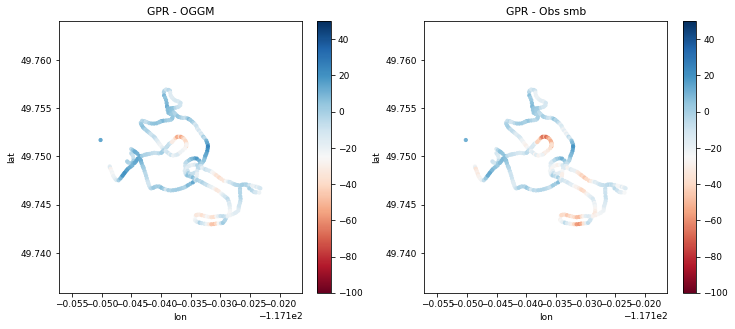

In [47]:
#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, (ax,ax1) = plt.subplots(1,2, figsize=(12, 5))
df_agg['GPR-oggm'] = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-oggm'], cmap='RdBu', s=10, ax=ax, vmax=50, vmin=-100); #cmap='Blues',
ax.title.set_text('GPR - OGGM')
# geom.plot(ax=ax, facecolor='no
#GPR depth less OGGM SMB thickness


geom = gdir.read_shapefile('outlines')
df_agg['GPR-obs_smb'] = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-obs_smb'], cmap='RdBu', s=10, vmax=50, vmin=-100, ax=ax1); #cmap='Blues',
ax1.title.set_text('GPR - Obs smb')
# geom.plot(ax=ax) #facecolor='no)

In [270]:
# gdir

In [49]:
# df_agg.to_csv(products_dir + glacier[num] + '_MBgrad.csv', index=False)
# ds_new.to_netcdf(products_dir + glacier[num] + '_MBgrad_gridded.nc')

In [269]:
# ds_new

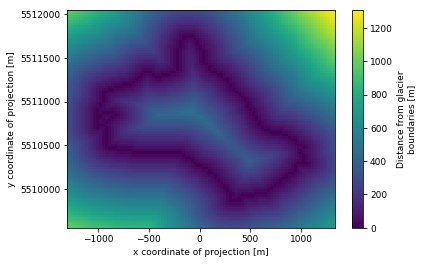

In [52]:
ds_new.dis_from_border.plot();

In [119]:
# Distance from border (normalized)
# msk = ds_new['glacier_mask'] 
# msk[msk == 0] = np.nan

dis_from_border_exp = 0.25
ds_new['dis_from_border25'] = ds_new.dis_from_border**dis_from_border_exp
ds_new['dis_from_border25'] /= np.mean(ds_new['dis_from_border25'])#[ds_new['glacier_mask'] == 1]
ds_new['thick'] = ds_new.distributed_thickness * ds_new.dis_from_border25
ds_new['dis_from_border25'] *= ds_new['glacier_mask']

dis_from_border_exp = 0.0
ds_new['dis_from_border0'] = ds_new.dis_from_border**dis_from_border_exp
ds_new['dis_from_border0'] /= np.mean(ds_new['dis_from_border0'])#[ds_new['glacier_mask'] == 1]
ds_new['thick'] = ds_new.distributed_thickness * ds_new.dis_from_border0
ds_new['dis_from_border0'] *= ds_new['glacier_mask']

dis_from_border_exp = 0.5
ds_new['dis_from_border5'] = ds_new.dis_from_border**dis_from_border_exp
ds_new['dis_from_border5'] /= np.mean(ds_new['dis_from_border5'])#[ds_new['glacier_mask'] == 1]
ds_new['thick'] = ds_new.distributed_thickness * ds_new.dis_from_border5
ds_new['dis_from_border5'] *= ds_new['glacier_mask']



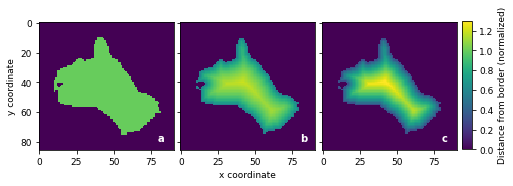

In [268]:
k = 0
items = ds_new['dis_from_border0'], ds_new['dis_from_border25'], ds_new['dis_from_border5']
letter = 'a', 'b', 'c'

fig, axes = plt.subplots(1,3, figsize=(7, 2.75), sharey=True)

for i in range(3):
    im = axes[k].imshow(items[i], vmax=1.3)  # don't specify j,k if only one row.
    axes[i].text(80,80, letter[i], fontweight='bold', fontsize=10, color='w')
    k += 1
    axes[0].set_ylabel('y coordinate')
    axes[1].set_xlabel('x coordinate')
    
    
fig.subplots_adjust(bottom=0.0, top=1.0, left=0.07, right=0.9,
                    wspace=0.05, hspace=0.02)

cb_ax = fig.add_axes([0.91, 0.18, 0.02, 0.65])
cbar = fig.colorbar(im, cax=cb_ax, label='Distance from border (normalized)')
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75)

# plt.tight_layout();
plt.savefig(products_dir + glacier[num] + '_distance_from_border.pdf', dpi=300)

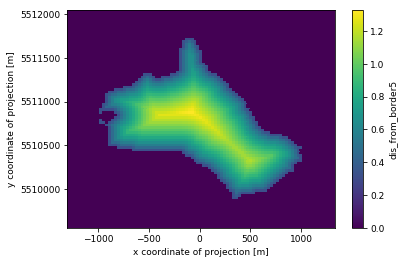

In [267]:
ds_new['dis_from_border5'].plot()